<a href="https://colab.research.google.com/github/BarchilhaMateus/Randomized-Signature-Methods-in-Portfolio-Optimization---Replication-/blob/main/ArtigoSignature_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching Data

In [ ]:
import yfinance as yf
import pandas as pd

# List of 17 Brazilian stocks
tickers = ['MGLU3.SA', 'B3SA3.SA', 'VALE3.SA', 'ABEV3.SA', 'MRVE3.SA', 'PRIO3.SA', 'WEGE3.SA', 'BEEF3.SA', 'PETR3.SA', 'PETR4.SA', 'MRFG3.SA', 'SLCE3.SA', 'MDIA3.SA', 'ELET3.SA', 'ITSA4.SA', 'SUZB3.SA', 'BBDC3.SA']

# Start and end dates
start_date = '2018-01-01'
end_date = '2024-01-08'

# Initialize an empty list to store dataframes
dataframes = []

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)

    if data.empty:
        print(f"No data found for {ticker}.")  # Checking for missing values
        continue

    data['Ticker'] = ticker  # Add a column for the ticker
    dataframes.append(data)  # Append the DataFrame to the list

# Concatenate all dataframes in the list
stock_data = pd.concat(dataframes)

# Handling NaNs
stock_data.dropna(inplace=True)

# Final check of the DataFrame
if stock_data.isnull().any().any():
    print("There are still NaN values after processing.")
else:
    print("DataFrame is ready to be saved.")

# Save the data
stock_data.to_csv('stock_data_5_years.csv', index=True)  # Set index=True to include dates in the CSV



In [ ]:
stock_data.tail() #checking

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2023-12-28,15.24,15.36,15.21,15.28,15.262556,3375400,BBDC3.SA
2024-01-02,15.26,15.26,14.98,15.11,15.092750,4545600,BBDC3.SA
2024-01-03,15.03,15.22,15.00,15.10,15.100000,2979400,BBDC3.SA
2024-01-04,15.06,15.13,14.87,14.90,14.900000,4189100,BBDC3.SA
2024-01-05,14.89,15.18,14.80,15.15,15.150000,3674400,BBDC3.SA


Reservoir

In [ ]:
import numpy as np
import pandas as pd

#Loading data
stock_data = pd.read_csv('stock_data_10_years.csv', parse_dates=['Date'], index_col='Date')

# Logarithmic Returns
stock_data['Log_Return'] = stock_data.groupby('Ticker')['Close'].transform(lambda x: np.log(x).diff())
stock_data.dropna(subset=['Log_Return'], inplace=True)

# Creating a table for log returns
log_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Log_Return')
num_stocks = len(log_returns.columns)


# Constructing Reservoir
np.random.seed(42)
r_d = 10
d = num_stocks
A = [np.random.randn(r_d, r_d) for _ in range(d)]
b = [np.random.randn(r_d) for _ in range(d)]
Z = np.zeros((len(log_returns), r_d))

#Activation Function
def activation_function(x):
    return np.tanh(x)

# Signature
for t in range(1, len(log_returns)):
    X_t = log_returns.iloc[t].values
    Z_sum = np.zeros(r_d)
    for i in range(d):
        # Dimension Problem
        if A[i].shape[1] != Z[t-1].shape[0]:
            raise ValueError(f"Erro de dimensionalidade: A[{i}].shape[1] != Z[t-1].shape[0]")
        Z_sum += A[i] @ Z[t-1] + b[i] * X_t[i]
    Z[t] = activation_function(Z_sum)

In [ ]:
Z[t]

array([-1.        , -0.75803779, -0.99999848,  0.99999972, -1.        ,
       -1.        , -0.9999992 , -1.        ,  0.9999968 ,  0.99967268])

Additional Imputs

In [ ]:
import yfinance as yf

# Download VIX Index data for the same period as the stock data - additional imputs mentioned in the article
vix_data = yf.download("^VIX", start=start_date, end=end_date)
vix_closing_prices = vix_data['Close']

mean_returns = log_returns.mean(axis=1)
volatility_mean_returns = mean_returns.rolling(window=21).std()  # 21 trading days for a month

volatility_stocks = log_returns.rolling(window=21).std()
additional_inputs = pd.concat([volatility_mean_returns, volatility_stocks, vix_closing_prices], axis=1).fillna(0)


[*********************100%%**********************]  1 of 1 completed


Ridge Regression Model - ML

In [ ]:
# Ensure that both DataFrames have the same dates
common_dates = log_returns.index.intersection(additional_inputs.index)
# Filter both DataFrames to include only the common dates
clean_log_returns = log_returns.loc[common_dates].dropna()
clean_additional_inputs = additional_inputs.loc[common_dates].dropna()

# Setting burn_in period as described in the Parameters Table
total_dias = len(clean_log_returns)
dias_burn_in = int(total_dias * 0.1)  # 10% of total days
data_separacao = clean_log_returns.index[dias_burn_in]

# Divide I_burn set and I_train set
I_burn = clean_log_returns[:data_separacao]
I_train = clean_log_returns[data_separacao:]

from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge

# Ensure that the column names of additional_inputs are all strings
additional_inputs.columns = additional_inputs.columns.astype(str)

# Define the imputer
imputer = SimpleImputer(strategy='mean')

# Impute NaN values in Z and additional_inputs
Z_imputed = imputer.fit_transform(Z)
additional_inputs_imputed = imputer.fit_transform(additional_inputs)

def construct_input_data(t, Z, additional_inputs):
    if t < len(additional_inputs):
        return np.hstack((Z[t], additional_inputs[t]))
    else:
        return Z[t]

# Define the Ridge Regression model
ridge_model = Ridge(alpha=10**-3)

# Initialize the predictions list
predictions = []

for t in range(len(I_train) - 1):
    X_train = construct_input_data(t, Z_imputed, additional_inputs_imputed)
    if X_train.ndim == 1:
        X_train = X_train.reshape(1, -1)

    for stock_index in range(num_stocks):
        y_train = I_train.iloc[t+1, stock_index]

        if not np.isnan(y_train):
            ridge_model.fit(X_train, [y_train])
            y_pred = ridge_model.predict(X_train)
            predictions.append((t, stock_index, y_pred[0]))

# Convert predictions list to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Time', 'Stock_Index', 'Prediction'])

Covariance Estimation

In [ ]:
from sklearn.covariance import LedoitWolf
import numpy as np
import pandas as pd

#
# Fill NaN values with the mean log return of each stock
log_returns_filled = log_returns.fillna(log_returns.mean())

# Initialize the LedoitWolf covariance estimator
lw = LedoitWolf()

# Fit the LedoitWolf model to the filled data
shrunk_cov_matrix = lw.fit(log_returns_filled).covariance_

Portfolio Optimization

In [ ]:
import numpy as np
import cvxpy as cp
import pandas as pd

# Convert the predictions list to a numpy array and then to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Time', 'Stock_Index', 'Prediction'])

# Pivot the DataFrame to get a matrix of predictions (time vs stock)
predictions_pivot = predictions_df.pivot(index='Time', columns='Stock_Index', values='Prediction')

# Fill any NaN values
predictions_filled = predictions_pivot.fillna(method='ffill').fillna(method='bfill')

# Calculate the mean prediction for each stock
mu_hat = predictions_filled.mean(axis=0).values.reshape(-1, 1)

# Ensure w is a column vector with dimensions (num_stocks, 1)
w = cp.Variable((num_stocks, 1))
r_f = 0.1175/252
max_risk = 0.5

# Optimization problem setup
excess_ret = cp.matmul(w.T, mu_hat) - r_f
risk = cp.quad_form(w, shrunk_cov_matrix)
objective = cp.Maximize(excess_ret)

# Constraints
constraints = [
    cp.sum(w) == 1,  # Sum of weights should be 1
    w >= 0,          # No short selling
    w <= 0.2,        # Maximum weight per stock
    risk <= max_risk # Maximum allowable risk
]
# Form and solve the problem
prob = cp.Problem(objective, constraints)
prob.solve()

# Check the status of the problem
print("Status:", prob.status)
if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
    optimized_weights = w.value.flatten()  # Flatten the result
    print("Optimized weights:", optimized_weights)
else:
    print("Problem has no optimal solution.")


stock_prices = stock_data.pivot_table(index='Date', columns='Ticker', values='Close')

Status: optimal
Optimized weights: [1.39372769e-07 1.99984460e-01 1.78871958e-07 2.44179647e-07
 1.99999556e-01 2.90596951e-07 1.98506471e-07 9.69518754e-08
 3.61621745e-07 1.56075624e-07 9.22812874e-06 1.99998572e-01
 1.99999943e-01 5.85943966e-06 3.35534373e-07 6.01274081e-07
 1.99999780e-01]


Adding Transaction Costs and Getting the final shares

In [ ]:
import pandas as pd
import numpy as np

# Define lambda as a fraction and tau
lambda_day_trade = 2.90 / 10000  # Fraction for day trade cost
lambda_swing_trade = 4.90 / 10000  # Fraction for swing trade cost
tau = 0.01  # Trading signal threshold

k = 5  #  5-day moving average
initial_portfolio_value = 60000  # For example, R$100,000

# Initialize portfolio shares and value
num_stocks = len(optimized_weights)
valor_alocado = optimized_weights * initial_portfolio_value


portfolio_value = initial_portfolio_value  # Set an initial portfolio value

# Initialize DataFrame to store updates

portfolio_updates = []

# Simulating the portfolio updates
for t in range(1, len(predictions_filled)):
    current_prices = stock_prices.iloc[t]  # Current stock prices
    previous_prices = stock_prices.iloc[t-1]  # Previous day's stock prices
    current_weights = optimized_weights  # Current day's optimized weights
    valor_alocado = optimized_weights * initial_portfolio_value
    shares = valor_alocado / current_prices
    # Calculate the portfolio's new value and the change in predicted returns
    new_portfolio_value = np.sum(shares * current_prices)
    delta_returns = predictions_filled.iloc[t] - predictions_filled.iloc[t-1]

    # Check if the change in returns is above the threshold
    if np.abs(delta_returns).max() >= tau:
        new_shares = (current_weights * new_portfolio_value) / current_prices
    else:
        new_shares = shares  # No change in shares if the threshold is not met


    # Calculate and apply transaction costs
    transaction_costs = lambda_day_trade * np.sum(np.abs(new_shares - shares) * current_prices)
    portfolio_value -= transaction_costs
    shares = new_shares
    update = {"Time": t, "Portfolio Value": portfolio_value, "Transaction Costs": transaction_costs}
    for i, share in enumerate(new_shares):
        update[f"Shares_{i}"] = share
    portfolio_updates.append(update)
    # Convert to DataFrame
    portfolio_updates_df = pd.DataFrame(portfolio_updates)


# Calculate the moving average of shares for each stock
for i in range(num_stocks):
    portfolio_updates_df[f"MA Shares_{i}"] = portfolio_updates_df[f"Shares_{i}"].rolling(window=k).mean()

# Normalize the shares after moving average
for t in range(len(portfolio_updates_df)):
    ma_shares = np.array([portfolio_updates_df.at[t, f"MA Shares_{i}"] for i in range(num_stocks)])
    total_investment = np.sum(ma_shares * current_prices)

    # Check if total investment is zero to avoid division by zero
    if total_investment != 0:
        normalized_shares = ma_shares * (portfolio_value / total_investment)
    else:
        # Handle the case where total investment is zero
        normalized_shares = ma_shares

    for i, share in enumerate(normalized_shares):
        portfolio_updates_df.at[t, f"Normalized Shares_{i}"] = share

# Final portfolio updates
final_shares = [portfolio_updates_df[f"Normalized Shares_{i}"].iloc[-1] for i in range(num_stocks)]

Generating Stochastic Returns to Compare with True Returns

In [ ]:
import numpy as np
import pandas as pd


# Calculate the annualized mean (drift) and volatility (sigma) for each stock
mu = log_returns.mean() * 252
sigma = log_returns.std() * np.sqrt(252)

# Convert the series to numpy arrays
mu = mu.values
sigma = sigma.values

# Number of stocks
n_stocks = len(mu)

# Number of time steps
T = len(log_returns)

# Initial stock prices
S0 = np.exp(log_returns.iloc[0].values)

# Time step size
dt = 1 / 252

# Correlated Brownian motions
# Assuming no correlation for simplicity
R = np.eye(n_stocks)
L = np.linalg.cholesky(R)
dW = np.random.normal(size=(T, n_stocks)) @ L.T

# Simulate stock prices including the true drifts
S = np.zeros((T, n_stocks))
S[0, :] = S0
for t in range(1, T):
    drift = mu - (0.5 * sigma ** 2)  # Adjust drift based on Ito's lemma
    # Aplicando a fórmula do artigo para o drift verdadeiro
    true_drift = S[t-1, :] * mu * np.cos(0.3 * np.sum(S[t-1, :]))
    S[t, :] = S[t-1, :] * np.exp(true_drift * dt + sigma * np.sqrt(dt) * dW[t-1, :])


# Simulate stock prices
S = np.zeros((T, n_stocks))
S[0, :] = S0
for t in range(1, T):
    drift = mu - (0.5 * sigma ** 2)  # Adjust drift based on Ito's lemma
    S[t, :] = S[t-1, :] * np.exp(drift * dt + sigma * np.sqrt(dt) * dW[t-1, :])
# Simulate stock prices including the true drifts
S = np.zeros((T, n_stocks))
S[0, :] = S0
for t in range(1, T):
    drift = mu - (0.5 * sigma ** 2)  # Adjust drift based on Ito's lemma
    # Aplicando a fórmula do artigo para o drift verdadeiro
    true_drift = S[t-1, :] * mu * np.cos(0.3 * np.sum(S[t-1, :]))
    S[t, :] = S[t-1, :] * np.exp(true_drift * dt + sigma * np.sqrt(dt) * dW[t-1, :])

# Convert the simulated prices to a DataFrame
dates = pd.date_range(start=log_returns.index[0], periods=T, freq='B')
# Convert the simulated prices to a DataFrame
simulated_data = pd.DataFrame(S, index=dates, columns=log_returns.columns)


Plotting the results to see if the Predicted Returns are compatible with True Returns

IC Médio: 0.004877539757050982


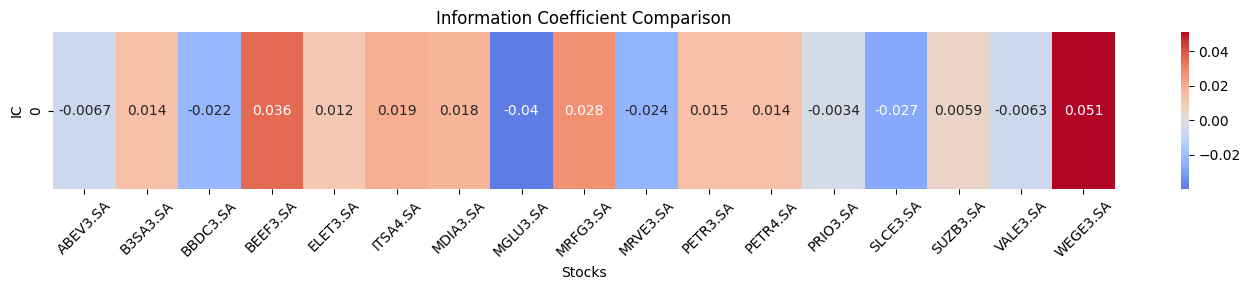

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# True drifts for stocks
S = np.zeros((T, n_stocks))
S[0, :] = S0
for t in range(1, T):
    #Stochastic return
    true_drift = S[t-1, :] * mu * np.cos(0.3 * np.sum(S[t-1, :]))
    S[t, :] = S[t-1, :] * np.exp(true_drift * dt + sigma * np.sqrt(dt) * dW[t-1, :])

# To Dataframe
simulated_data = pd.DataFrame(S, index=dates, columns=log_returns.columns)

#Predictions filled as the predictions return
previsoes_retorno = predictions_filled.to_numpy() if isinstance(predictions_filled, pd.DataFrame) else predictions_filled

# Set the true drifts
drifts_verdadeiros = S[1:, :] * mu * np.cos(0.3 * np.sum(S[:-1, :], axis=1)[:, np.newaxis])

# Predictions filled as nparray
previsoes_retorno = predictions_filled.to_numpy() if isinstance(predictions_filled, pd.DataFrame) else predictions_filled

# Adjust arrays to have the same rows
menor_tamanho = min(previsoes_retorno.shape[0], drifts_verdadeiros.shape[0])
previsoes_retorno = previsoes_retorno[:menor_tamanho, :]
drifts_verdadeiros = drifts_verdadeiros[:menor_tamanho, :]

# Measuring IC
ICs = [np.corrcoef(previsoes_retorno[:, i], drifts_verdadeiros[:, i])[0, 1] for i in range(n_stocks)]

# IC mean
media_IC = np.nanmean(ICs)
print("IC Médio:", media_IC)

#Plotting IC
plt.figure(figsize=(14, 3))
sns.heatmap(np.array([ICs]), annot=True, cmap='coolwarm', center=0)  # Modificado para exibir corretamente como heatmap
plt.title('Information Coefficient Comparison')
plt.xlabel('Stocks')
plt.ylabel('IC')
plt.xticks(ticks=np.arange(n_stocks) + 0.5, labels=simulated_data.columns, rotation=45)
plt.tight_layout()
plt.show()




Plotting the simulated data

In [ ]:
import plotly.graph_objects as go


fig = go.Figure()

# Add traces for each stock
for stock in simulated_data.columns:
    fig.add_trace(go.Scatter(x=simulated_data.index, y=simulated_data[stock], mode='lines', name=stock))

# Update layout for a clearer view
fig.update_layout(title='Paths of Simulated Stocks Over 10 Years',
                  xaxis_title='Time',
                  yaxis_title='Stock Price',
                  legend_title='Stocks')

# Show figure
fig.show()